In [ ]:
# Imports and config 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import gpflow as gf
from sklearn.preprocessing import StandardScaler

import preprocessing as prep
import kernels as gkern
import inducing_variables as gind
import training as gtrain  
import utils               

# GPU config 
print("GPUs:", tf.config.list_physical_devices("GPU"))
for g in tf.config.list_physical_devices("GPU"):
    tf.config.experimental.set_memory_growth(g, True)

gf.config.set_default_float(tf.float64)
tf_float = gf.config.default_float()
np_float = tf.as_dtype(tf_float).as_numpy_dtype


2025-09-06 12:35:50.918939: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-06 12:36:04.286620: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757158568.381983   39361 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757158570.144725   39361 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1757158578.866739   39361 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# ========================= CONFIG =========================
import numpy as np
import pandas as pd

LOOKBACK = 60

H = 30

TRAIN_FRAC = 0.70
VAL_FRAC   = 0.15  

# base features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

df = pd.read_csv("aluminium_raw_inputs.csv", parse_dates=['date']).sort_values('date')

df["log_returns"] = np.log(df["al_lme_prices"] / df["al_lme_prices"].shift(1))
df = df.dropna()

df["vol"]      = df["log_returns"].rolling(window=30).std() * np.sqrt(252)
df["log_vol"]  = np.log(df["vol"] + 1e-12)

df["target_vol"]     = df["vol"].shift(-H)
df["target_log_vol"] = np.log(df["target_vol"] + 1e-12)


df["lag1_log_vol"]   = df["log_vol"].shift(1)
df["lag7_log_vol"]   = df["log_vol"].shift(7)
df["lag30_log_vol"]  = df["log_vol"].shift(30)

df = df.dropna().reset_index(drop=True)

print(df[["date","log_returns","vol","target_vol"]].head(3))
print(df[["date","log_returns","vol","target_vol"]].tail(3))

keep = ["log_returns", "log_vol", "lag1_log_vol", "lag7_log_vol", "lag30_log_vol"]
df_base = df[["date"] + keep + ["target_log_vol"]].copy()


        date  log_returns       vol  target_vol
0 2016-04-08     0.012886  0.158188    0.192438
1 2016-04-11    -0.005837  0.153134    0.191867
2 2016-04-12     0.019051  0.164589    0.184262
           date  log_returns       vol  target_vol
2353 2025-04-16     0.004728  0.175209    0.194270
2354 2025-04-17    -0.006512  0.164585    0.195644
2355 2025-04-18     0.000000  0.162905    0.196028


In [ ]:
T = len(df)
all_t = list(range(LOOKBACK, T))

n_total = len(all_t)
n_tr = int(np.floor(n_total * TRAIN_FRAC))
n_va = int(np.floor(n_total * VAL_FRAC))
n_te = n_total - n_tr - n_va
assert n_tr > 0 and n_va > 0 and n_te > 0, "Dataset too small for the chosen splits/LOOKBACK."

idx_tr_win = list(range(0, n_tr))
idx_va_win = list(range(n_tr, n_tr + n_va))
idx_te_win = list(range(n_tr + n_va, n_total))

cutoff_row = LOOKBACK + idx_tr_win[-1] + 1


In [ ]:
X_list, y_list = [], []

train_means_F = df_base.loc[:cutoff_row-1, keep].mean(numeric_only=True)
F_df = df_base[keep].copy()
F_df = F_df.fillna(train_means_F)  

F   = F_df.to_numpy(dtype=np.float64)
y_l = df_base["target_log_vol"].to_numpy(dtype=np.float64)

for t in all_t:
    x_win = F[t-LOOKBACK:t, :]  
    X_list.append(x_win)
    y_list.append(y_l[t])        

X_list = prep.add_time_to_list(X_list)
y = np.asarray(y_list, dtype=np.float64)

X_tr_list = [X_list[i] for i in idx_tr_win]
X_va_list = [X_list[i] for i in idx_va_win]
X_te_list = [X_list[i] for i in idx_te_win]
y_tr_log  = y[idx_tr_win]
y_va_log  = y[idx_va_win]
y_te_log  = y[idx_te_win]

# scaling
from sklearn.preprocessing import StandardScaler
time_is_first = False

if time_is_first:
    def scale_list(lst, scaler=None):
        outs, scal = [], scaler
        for x in lst:
            tcol = x[:, :1]
            fcol = x[:, 1:]
            if scal is None:
                scal = StandardScaler().fit(fcol)
            outs.append(np.concatenate([tcol, scal.transform(fcol)], axis=1))
        return outs, scal

    X_tr_list, scaler_X = scale_list(X_tr_list, scaler=None)
    X_va_list, _        = scale_list(X_va_list, scaler_X)
    X_te_list, _        = scale_list(X_te_list, scaler_X)
else:
    stack_tr = np.concatenate(X_tr_list, axis=0)
    scaler_X = StandardScaler().fit(stack_tr)
    X_tr_list = [scaler_X.transform(x) for x in X_tr_list]
    X_va_list = [scaler_X.transform(x) for x in X_va_list]
    X_te_list = [scaler_X.transform(x) for x in X_te_list]

X_tr = prep.tabulate_list_of_sequences(X_tr_list)
X_va = prep.tabulate_list_of_sequences(X_va_list)
X_te = prep.tabulate_list_of_sequences(X_te_list)

scaler_y = StandardScaler().fit(y_tr_log.reshape(-1,1))
y_tr = scaler_y.transform(y_tr_log.reshape(-1,1)).ravel()
y_va = scaler_y.transform(y_va_log.reshape(-1,1)).ravel()
y_te = scaler_y.transform(y_te_log.reshape(-1,1)).ravel()

print("Shapes — X_tr", X_tr.shape, "X_va", X_va.shape, "X_te", X_te.shape)
print("Done. Use X_tr/X_va/X_te and y_tr/y_va/y_te in your GP.")


100%|██████████| 345/345 [00:00<00:00, 3797991.81it/s]

Shapes — X_tr (1607, 60, 6) X_va (344, 60, 6) X_te (345, 60, 6)
Done. Use X_tr/X_va/X_te and y_tr/y_va/y_te in your GP.


In [ ]:
# Model: kernel, inducing, mean 
num_train, L, d = X_tr.shape
input_dim    = L * d
num_levels   = 3
num_lags     = 0
num_inducing = min(200, num_train)

# Inducing init
try:
    Z_init = utils.suggest_initial_inducing_tensors_tf2(
        X_tr, num_levels, num_inducing, increments=False, num_lags=num_lags
    )
except Exception:
    sel = np.random.RandomState(0).choice(len(X_tr), size=num_inducing, replace=False)
    Z_init = X_tr[sel]

feat = gind.InducingTensors(Z_init, num_levels=num_levels, increments=False)

# Lengthscale init 
try:
    l_init = utils.suggest_initial_lengthscales(X_tr, num_samples=1000)
except Exception:
    l_init = np.ones(d, dtype=np_float)

k = gkern.SignatureMix(
    input_dim=input_dim,
    num_features=d,
    num_levels=num_levels,
    lengthscales=l_init,
    difference=True
)

lik = gf.likelihoods.Gaussian()

from gpflow import mean_functions as mf

class SequenceConstant(mf.MeanFunction):
    """Trainable scalar c; returns (N,1) regardless of input rank."""
    def __init__(self, init=0.0):
        super().__init__()
        self.c = tf.Variable([[np_float(init)]], dtype=tf_float, trainable=True)  # shape (1,1)

    def __call__(self, X):
        X = tf.convert_to_tensor(X, dtype=tf_float)
        N = tf.shape(X)[0]
        return tf.tile(self.c, [N, 1])  # (N,1)

seq_const_mean = SequenceConstant(init=0.0)


import models
model = models.SVGPForSignatures(
    kernel=k,
    likelihood=lik,
    inducing_variable=feat,
    num_latent_gps=1,
    whiten=True,
    q_diag=True,
    mean_function=seq_const_mean,
)



I0000 00:00:1757158734.472029   39361 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22188 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6


2025-09-06 12:39:01.296323: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:187] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-06 12:39:02.375085: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:187] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-06 12:39:02.377948: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:187] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-06 12:39:02.381211: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:187] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-06 12:39:02.384972: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:187] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-06

In [ ]:
BATCH = 128
train_ds = (
    tf.data.Dataset
      .from_tensor_slices((X_tr.astype(np_float), y_tr.reshape(-1,1).astype(np_float)))
      .shuffle(len(X_tr))
      .repeat()                      
      .batch(BATCH)
      .prefetch(tf.data.AUTOTUNE)
)
train_it = iter(train_ds)

model.num_data = int(X_tr.shape[0])

loss_closure = model.training_loss_closure(train_it, compile=True)

In [ ]:
PRED_CHUNK = 128

def _to_tf3(X_seq):
    return tf.convert_to_tensor(X_seq, dtype=tf_float)

def _pred_scaled_batched(m, X_seq, chunk=PRED_CHUNK):
    """
    Predict mean/var in the SAME scaled log space used for training (y ~ N(mu, var)).
    Returns arrays shaped (N,).
    """
    N = len(X_seq)
    mu_parts, var_parts = [], []
    noise = float(m.likelihood.variance.numpy())
    for i in range(0, N, chunk):
        xb = _to_tf3(X_seq[i:i+chunk])
        f_mu, f_var = m.predict_f(xb)                 # (B,1), (B,1)
        y_mu  = tf.reshape(f_mu,  [-1]).numpy()
        y_var = tf.reshape(f_var, [-1]).numpy() + noise
        y_var = np.maximum(y_var, 1e-12)
        mu_parts.append(y_mu); var_parts.append(y_var)
    return np.concatenate(mu_parts), np.concatenate(var_parts)

def _unscale_log(mu_scaled, var_scaled):
    """
    Convert (mu, var) from scaled log space to unscaled log units.
    """
    mu_log = scaler_y.inverse_transform(mu_scaled.reshape(-1,1)).ravel()
    var_log = np.maximum(var_scaled, 0.0) * (scaler_y.scale_[0]**2)
    return mu_log, var_log

def rmse_log_batched(m, X_seq, y_scaled, chunk=PRED_CHUNK):
    """
    RMSE between predicted mean log-vol and true log-vol, in *unscaled log* units.
    """
    y_mu_s, _ = _pred_scaled_batched(m, X_seq, chunk)
    mu_log, _ = _unscale_log(y_mu_s, np.zeros_like(y_mu_s))
    true_log  = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).ravel()
    return float(np.sqrt(np.mean((mu_log - true_log)**2)))

def mae_log_batched(m, X_seq, y_scaled, chunk=PRED_CHUNK):
    y_mu_s, _ = _pred_scaled_batched(m, X_seq, chunk)
    mu_log, _ = _unscale_log(y_mu_s, np.zeros_like(y_mu_s))
    true_log  = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).ravel()
    return float(np.mean(np.abs(mu_log - true_log)))

def nlpp_scaled_batched(m, X_seq, y_scaled, chunk=PRED_CHUNK):
    """
    Negative log predictive probability in the scaled space (training loss).
    Kept for calibration checks; not directly comparable to GARCH.
    """
    y_mu_s, y_var_s = _pred_scaled_batched(m, X_seq, chunk)
    y = y_scaled.reshape(-1)
    ll = -0.5*(np.log(2*np.pi*y_var_s) + (y - y_mu_s)**2 / y_var_s)
    return float(-np.mean(ll))

# Use LOG-scale RMSE for validation/early stopping
val_rmse = lambda mm: rmse_log_batched(mm, X_va, y_va, PRED_CHUNK)
val_nlpp = lambda mm: nlpp_scaled_batched(mm, X_va, y_va, PRED_CHUNK)


In [ ]:
#  Train (freeze kernel -> unfreeze) 
def track_hypers(model_obj):
    info = {}

    try:
        Z = model_obj.inducing_variable.Z.numpy()
        info["Z_rms"] = float(np.sqrt(np.mean(Z**2)))
    except Exception:
        info["Z_rms"] = np.nan

    try:
        info["noise"] = float(model_obj.likelihood.variance.numpy())
    except Exception:
        info["noise"] = np.nan

    try:
        ls = model_obj.kernel.lengthscales.numpy()
        info["ls_med"] = float(np.median(ls))
    except Exception:
        info["ls_med"] = np.nan

    print(
        f"\t| noise={info['noise']:.3e} "
        f"ls_med={info['ls_med']:.3f} "
        f"Z_rms={info['Z_rms']:.3f}", end=""
    )
    return info


opt1 = tf.keras.optimizers.Nadam(1e-3)
opt2 = tf.keras.optimizers.Nadam(5e-4)

gf.set_trainable(model.kernel, False)
hist = gtrain.optimize(
    model, opt=opt1,
    max_iter=3000, print_freq=20, save_freq=100,
    val_scorer=[val_rmse, val_nlpp],
    save_params=False,
    loss_closure=loss_closure,
    callbacks=[track_hypers],
)

gf.set_trainable(model.kernel, True)
hist = gtrain.optimize(
    model, opt=opt2,
    max_iter=30000, print_freq=20, save_freq=200,
    val_scorer=[val_rmse, val_nlpp],
    history=hist,
    save_best_params=True, lower_is_better=True, patience=5000,
    loss_closure=loss_closure,
    callbacks=[track_hypers],
)


-------------------------
  Starting optimization  
-------------------------


2025-09-06 12:39:08.946294: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:187] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-06 12:39:09.024642: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:187] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-06 12:39:09.167713: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:187] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-06 12:39:09.275546: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:187] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-06 12:39:09.544571: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:187] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2025-09-06

Iteration 100	|	Time: 13.34	|	ELBO: -4980.824	| noise=1.059e+00 ls_med=1.000 Z_rms=1.044	|	Val.: 0.314621
Iteration 200	|	Time: 17.23	|	ELBO: -4376.148	| noise=1.114e+00 ls_med=1.000 Z_rms=1.037	|	Val.: 0.275794
Iteration 300	|	Time: 20.89	|	ELBO: -3827.963	| noise=1.163e+00 ls_med=1.000 Z_rms=1.034	|	Val.: 0.256355
Iteration 400	|	Time: 24.59	|	ELBO: -3550.290	| noise=1.203e+00 ls_med=1.000 Z_rms=1.034	|	Val.: 0.253972
Iteration 500	|	Time: 28.31	|	ELBO: -3318.603	| noise=1.237e+00 ls_med=1.000 Z_rms=1.035	|	Val.: 0.253978
Iteration 600	|	Time: 32.04	|	ELBO: -3086.839	| noise=1.264e+00 ls_med=1.000 Z_rms=1.037	|	Val.: 0.254888
Iteration 700	|	Time: 35.76	|	ELBO: -2958.258	| noise=1.286e+00 ls_med=1.000 Z_rms=1.039	|	Val.: 0.255484
Iteration 800	|	Time: 39.48	|	ELBO: -2930.397	| noise=1.304e+00 ls_med=1.000 Z_rms=1.041	|	Val.: 0.256707
Iteration 900	|	Time: 43.23	|	ELBO: -2758.043	| noise=1.318e+00 ls_med=1.000 Z_rms=1.043	|	Val.: 0.255219
Iteration 1000	|	Time: 46.96	|	ELBO: -2701.807

In [ ]:
model.kernel.lengthscales.numpy()

array([0.35975147, 0.85681841, 0.90682833, 1.59501033, 1.11407441,
       1.93293947, 1.55614246, 1.9614217 , 2.1677901 , 0.4313839 ,
       0.49450952, 0.68571642, 0.63760018, 0.49791351, 0.66421293,
       0.60940989, 1.76925922, 1.07302104, 1.37016302, 1.72447919,
       0.59677316, 0.96976538, 0.9070834 , 0.2979104 , 0.60847502,
       1.96128935, 0.8634256 , 1.30815551, 0.54293154, 1.41109546,
       0.81965679, 0.62761251, 1.23314932, 0.34279732, 1.0605532 ])

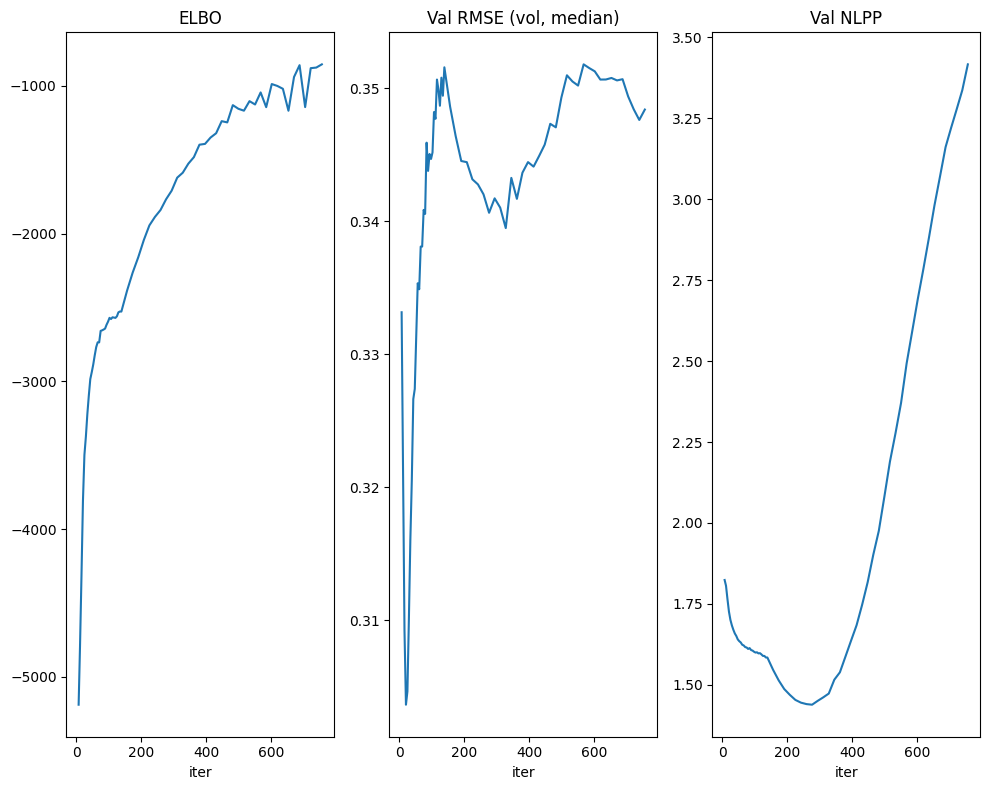

In [ ]:
# Training curves 
times, elbos, v1, v2 = [], [], [], []
for k, v in hist.items():
    if str(k).isdigit():
        times.append(v.get('time', np.nan))
        elbos.append(v.get('elbo', np.nan))
        if 'val' in v:
            v1.append(v['val'][0])
            v2.append(v['val'][1])

fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].plot(times, elbos);                 ax[0].set_title("ELBO"); ax[0].set_xlabel("iter")
if v1: ax[1].plot(times[:len(v1)], v1);   ax[1].set_title("Val RMSE (vol, median)"); ax[1].set_xlabel("iter")
if v2: ax[2].plot(times[:len(v2)], v2);   ax[2].set_title("Val NLPP"); ax[2].set_xlabel("iter")
plt.tight_layout(); plt.show()


[train]  RMSE_log: 0.078741   MAE_log: 0.057375
[valid]  RMSE_log: 0.348406   MAE_log: 0.284730
[test]  RMSE_log: 0.248844   MAE_log: 0.216621


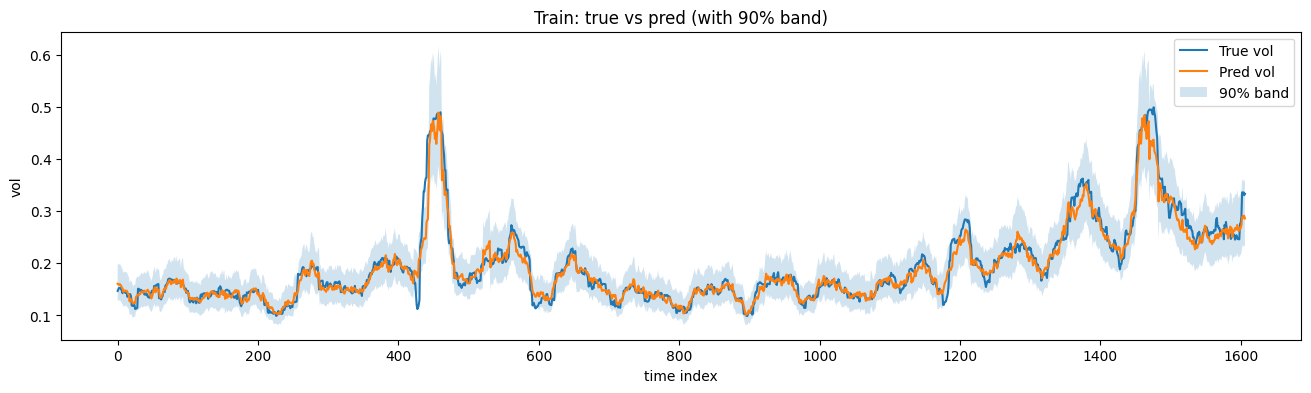

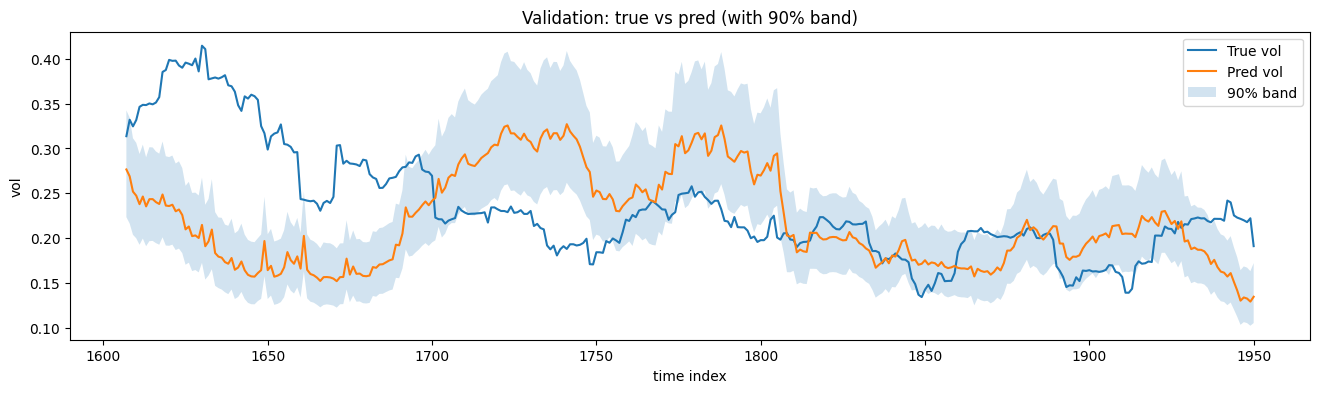

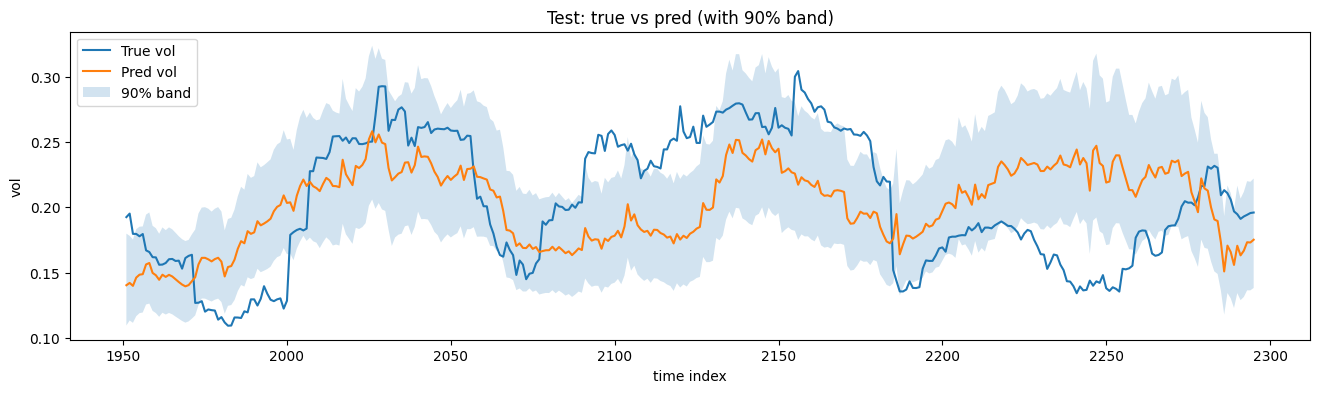

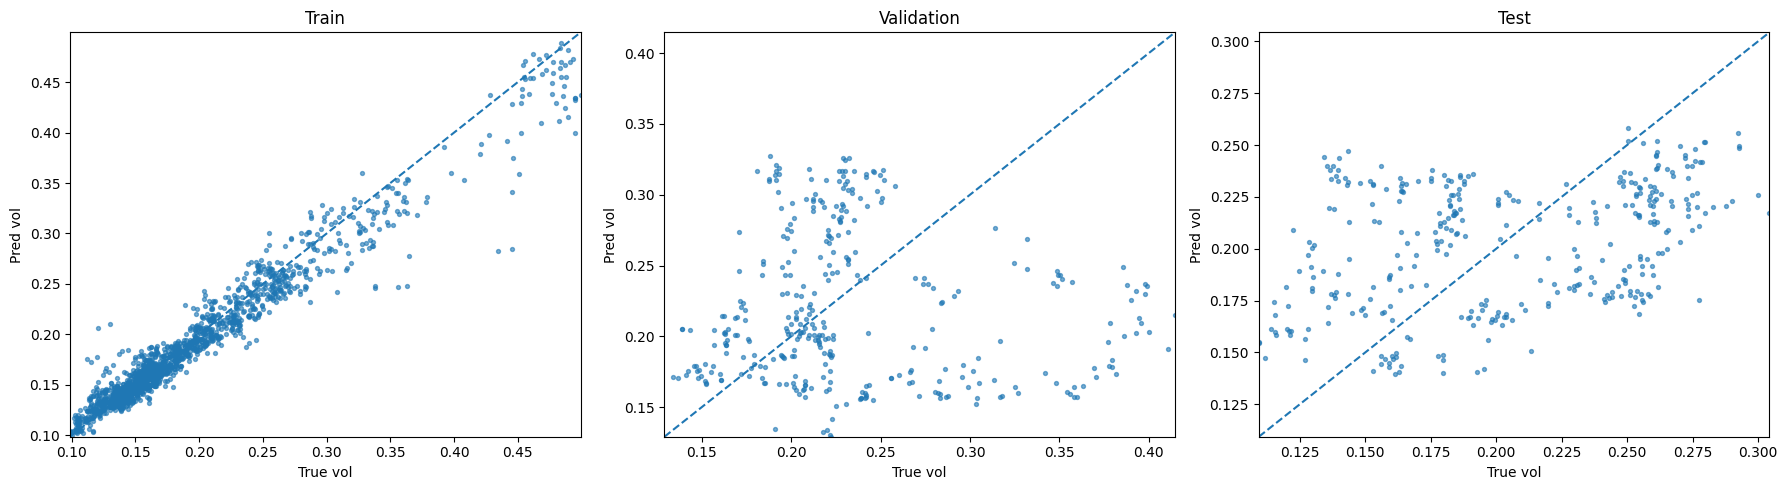

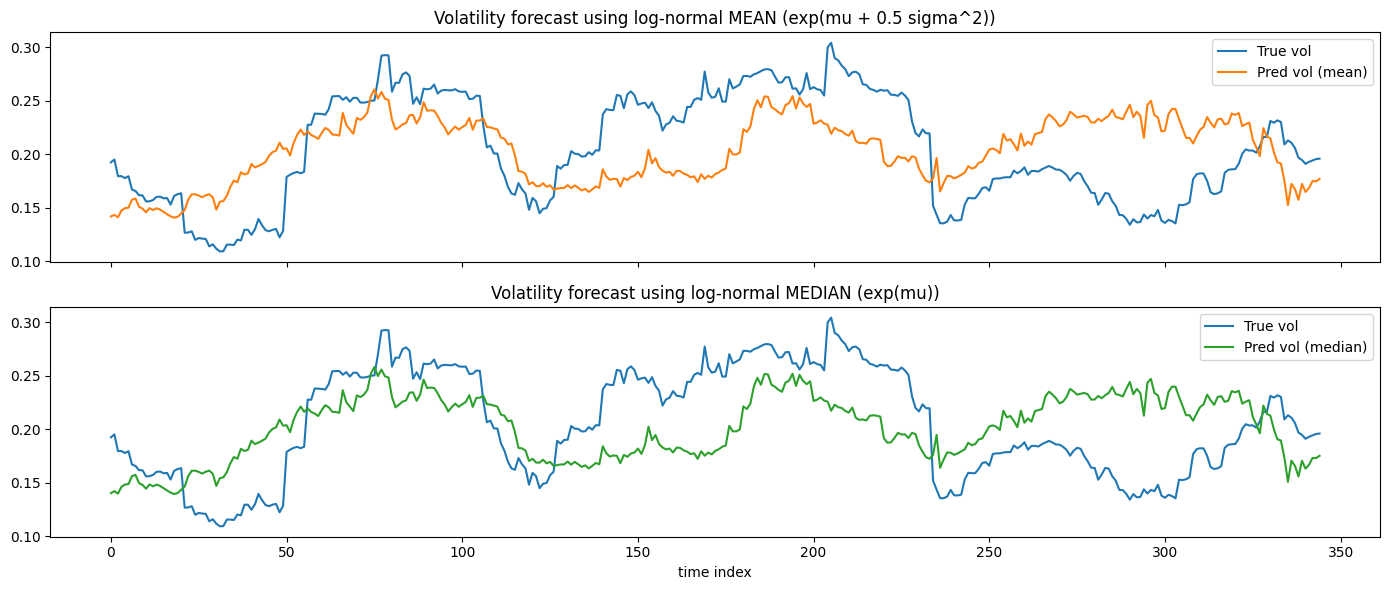

In [ ]:
# Evaluation & plots 
from scipy.stats import norm

PRED_CHUNK = 128  

def _pred_scaled_batched(m, X_seq, chunk=PRED_CHUNK):
    N = len(X_seq)
    mu_parts, var_parts = [], []
    noise = float(m.likelihood.variance.numpy())
    for i in range(0, N, chunk):
        xb = tf.convert_to_tensor(X_seq[i:i+chunk], dtype=tf_float)
        f_mu, f_var = m.predict_f(xb)                
        y_mu  = tf.reshape(f_mu,  [-1]).numpy()
        y_var = tf.reshape(f_var, [-1]).numpy() + noise
        y_var = np.maximum(y_var, 1e-12)
        mu_parts.append(y_mu); var_parts.append(y_var)
    return np.concatenate(mu_parts), np.concatenate(var_parts)

def _unscale_log(mu_scaled, var_scaled):
    mu_log  = scaler_y.inverse_transform(mu_scaled.reshape(-1,1)).ravel()
    var_log = np.maximum(var_scaled, 0.0) * (scaler_y.scale_[0]**2)
    return mu_log, var_log

def evaluate_split_log(name, X_seq, y_scaled, *, use_median=False):
    """
    Prints RMSE/MAE in log units. Also returns both log- and vol-scale
    quantities for plotting:
      - mu_log, var_log, true_log
      - pred_vol_mean (mean of lognormal) or pred_vol_median (median)
      - true_vol
      - q05_vol, q95_vol (90% band on vol)
    """
    # predictions in scaled log space
    y_mu_s, y_var_s = _pred_scaled_batched(model, X_seq)
    mu_log, var_log = _unscale_log(y_mu_s, y_var_s)
    true_log = scaler_y.inverse_transform(y_scaled.reshape(-1,1)).ravel()

    # LOG-scale metrics
    rmse_log = float(np.sqrt(np.mean((mu_log - true_log)**2)))
    mae_log  = float(np.mean(np.abs(mu_log - true_log)))
    print(f"[{name}]  RMSE_log: {rmse_log:.6f}   MAE_log: {mae_log:.6f}")

    # Convert to VOL scale for plots
    s_log = np.sqrt(var_log)
    true_vol = np.exp(true_log)

    if use_median:
        pred_vol = np.exp(mu_log)                 
    else:
        pred_vol = np.exp(mu_log + 0.5*var_log)    

    q05_vol = np.exp(mu_log + norm.ppf(0.05) * s_log)
    q95_vol = np.exp(mu_log + norm.ppf(0.95) * s_log)

    return {
        "mu_log": mu_log, "var_log": var_log, "true_log": true_log,
        "pred_vol": pred_vol, "true_vol": true_vol,
        "q05_vol": q05_vol, "q95_vol": q95_vol,
    }

res_tr = evaluate_split_log("train", X_tr, y_tr, use_median=True)
res_va = evaluate_split_log("valid", X_va, y_va, use_median=True)
res_te = evaluate_split_log("test",  X_te, y_te, use_median=True)

def ts_with_band(idx_start, res, title):
    pv = res["pred_vol"]; tv = res["true_vol"]
    q05, q95 = res["q05_vol"], res["q95_vol"]
    t = np.arange(idx_start, idx_start + len(pv))
    plt.figure(figsize=(16,4))
    plt.plot(t, tv, label="True vol")
    plt.plot(t, pv, label="Pred vol")
    plt.fill_between(t, q05, q95, alpha=0.2, label="90% band")
    plt.title(title); plt.legend(); plt.xlabel("time index"); plt.ylabel("vol"); plt.show()

# Time-series with bands
n_tr = len(res_tr["pred_vol"])
n_va = len(res_va["pred_vol"]) if res_va is not None else 0
n_te = len(res_te["pred_vol"])

ts_with_band(0,           res_tr, "Train: true vs pred (with 90% band)")
ts_with_band(n_tr,        res_va, "Validation: true vs pred (with 90% band)")
ts_with_band(n_tr + n_va, res_te, "Test: true vs pred (with 90% band)")

# Scatter plots (vol scale)
def scatter_split(ax, res, title):
    pv, tv = res["pred_vol"], res["true_vol"]
    lo = min(pv.min(), tv.min()); hi = max(pv.max(), tv.max())
    ax.scatter(tv, pv, s=8, alpha=0.6)
    ax.plot([lo,hi],[lo,hi], linestyle="--")
    ax.set_title(title); ax.set_xlabel("True vol"); ax.set_ylabel("Pred vol")
    ax.set_xlim(lo, hi); ax.set_ylim(lo, hi)

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
scatter_split(ax[0], res_tr, "Train"); scatter_split(ax[1], res_va, "Validation"); scatter_split(ax[2], res_te, "Test")
plt.tight_layout(); plt.show()


import matplotlib.pyplot as plt
import numpy as np

# Predict in scaled log-space
y_mu_s, y_var_s = _pred_scaled_batched(model, X_te)

# Unscale to original log-vol space
mu_log, var_log = _unscale_log(y_mu_s, y_var_s)  
true_log = scaler_y.inverse_transform(y_te.reshape(-1,1)).ravel()

pred_vol_mean   = np.exp(mu_log + 0.5 * var_log)   
pred_vol_median = np.exp(mu_log)                   
true_vol        = np.exp(true_log)

# Plot
fig, ax = plt.subplots(2, 1, figsize=(14,6), sharex=True)

ax[0].plot(true_vol, label="True vol", color="C0")
ax[0].plot(pred_vol_mean, label="Pred vol (mean)", color="C1")
ax[0].set_title("Volatility forecast using log-normal MEAN (exp(mu + 0.5 sigma^2))")
ax[0].legend()

ax[1].plot(true_vol, label="True vol", color="C0")
ax[1].plot(pred_vol_median, label="Pred vol (median)", color="C2")
ax[1].set_title("Volatility forecast using log-normal MEDIAN (exp(mu))")
ax[1].legend()

plt.xlabel("time index")
plt.tight_layout()
plt.show()


[train]  MSE_log: 0.006200   MAE_log: 0.057375
[valid]  MSE_log: 0.121387   MAE_log: 0.284730
[test]  MSE_log: 0.061923   MAE_log: 0.216621


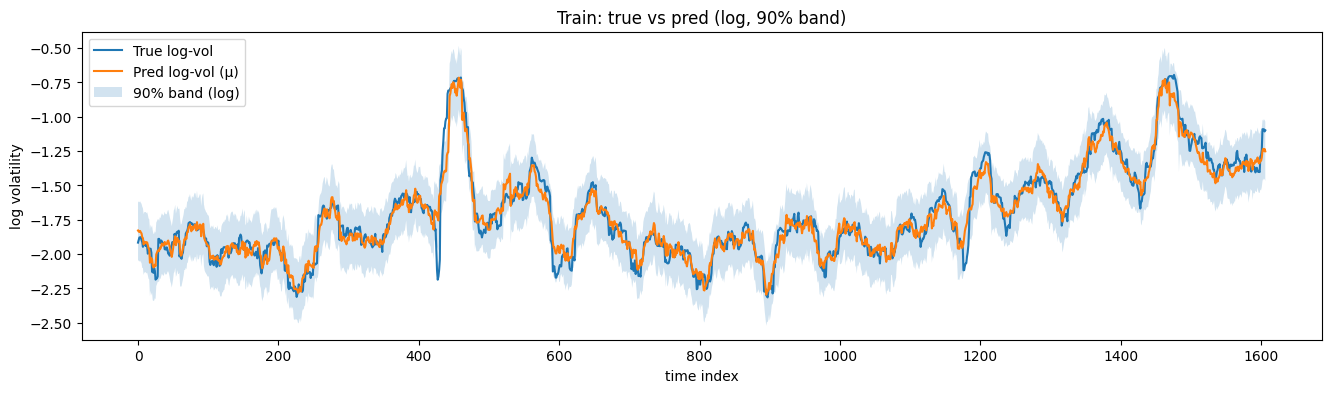

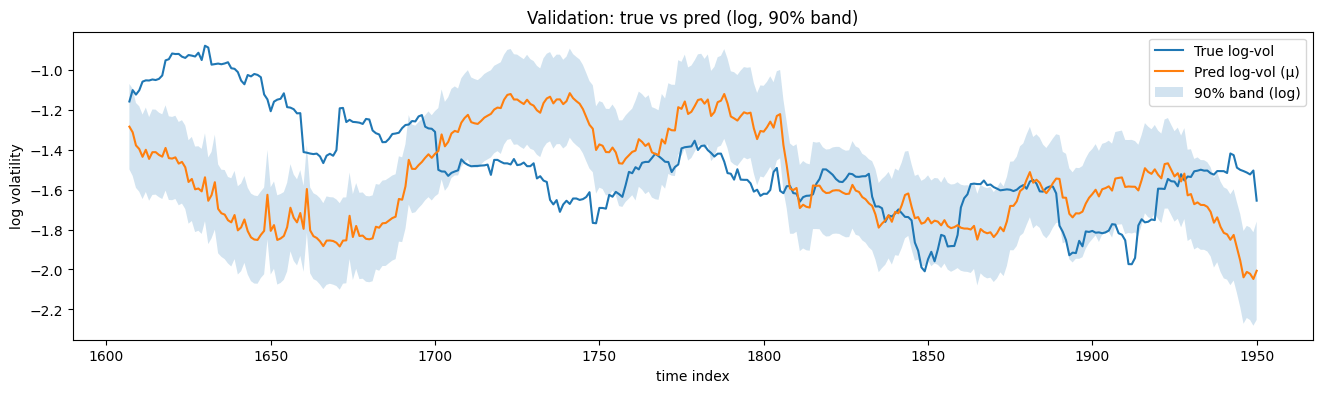

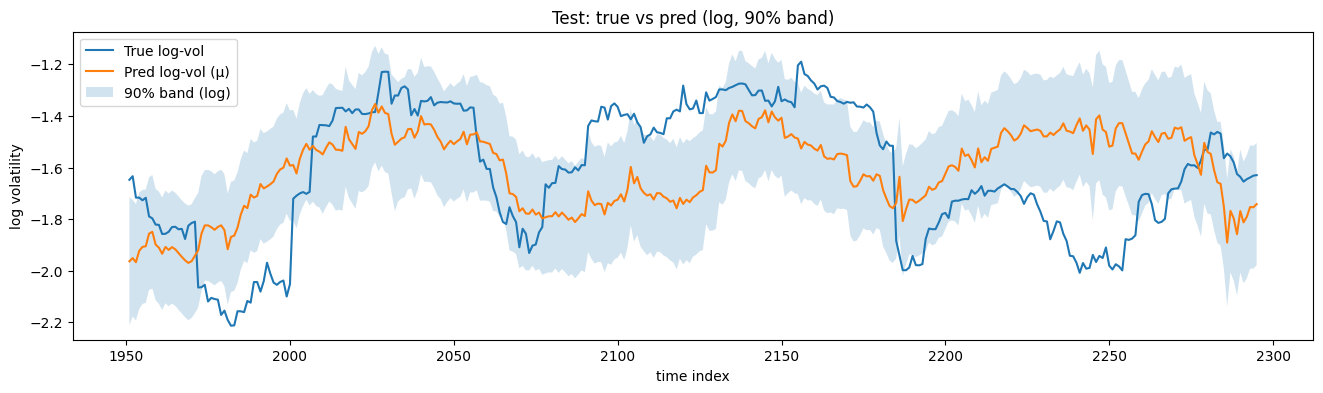

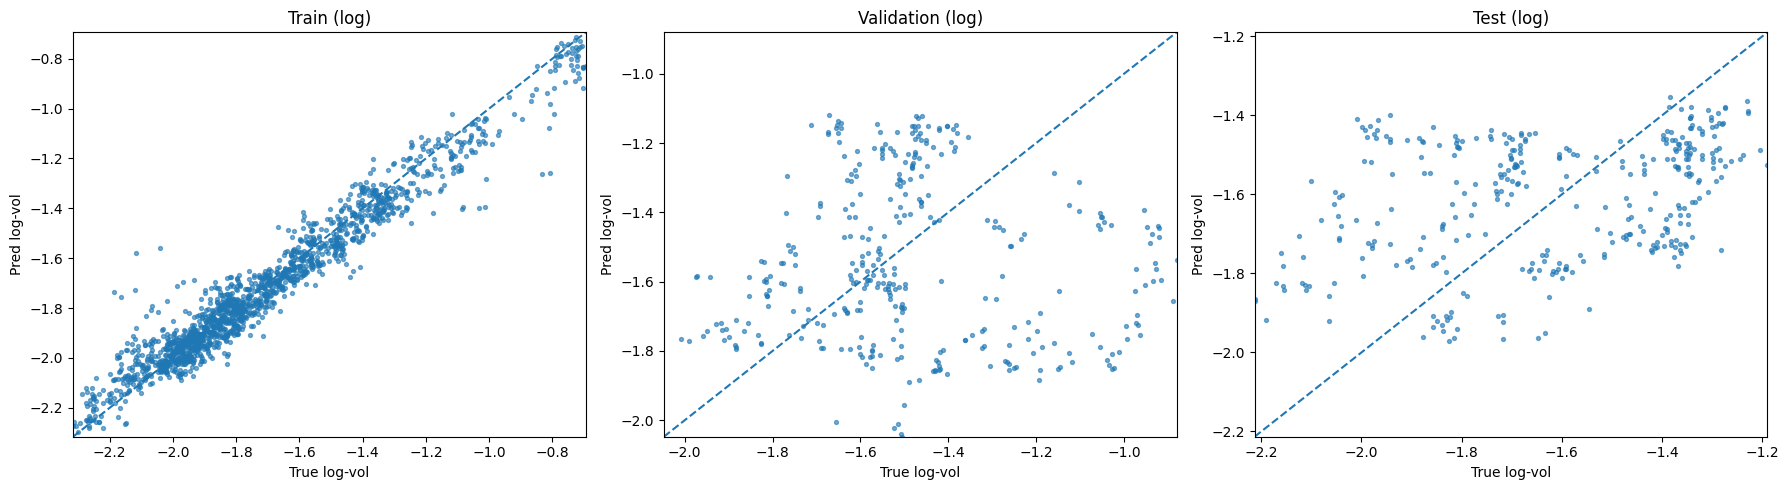

In [ ]:
# metrics and calibration
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm

os.makedirs("plots", exist_ok=True)

def interval_score(alpha, l, u, y):
    width = u - l
    under = (l - y) if y < l else 0.0
    over  = (y - u) if y > u else 0.0
    return width + (2.0/alpha)*under + (2.0/alpha)*over

def crps_gaussian(y, mu, sig):
    z   = (y - mu) / np.maximum(sig, 1e-12)
    pdf = norm.pdf(z); cdf = norm.cdf(z)
    return sig * (z * (2*cdf - 1) + 2*pdf - 1/np.sqrt(np.pi))

def summarize_split(name, res, alpha=0.10, save_prefix="siggp"):
    mu  = res["mu_log"]
    tl  = res["true_log"]
    s   = np.sqrt(res["var_log"])
    lo  = mu + norm.ppf(alpha/2) * s
    hi  = mu + norm.ppf(1 - alpha/2) * s

    # point metrics
    mae = float(mean_absolute_error(tl, mu))
    mse = float(mean_squared_error(tl, mu))

    # interval metrics
    cov = float(np.mean((tl >= lo) & (tl <= hi)))
    wid = float(np.mean(hi - lo))
    isv = float(np.mean([interval_score(alpha, lo[i], hi[i], tl[i]) for i in range(len(tl))]))

    # CRPS (Gaussian closed-form)
    crp = float(np.mean(crps_gaussian(tl, mu, s)))

    print(f"[{name}] MAE={mae:.6f}  MSE={mse:.6f}  Cov90={cov:.3f}  "
          f"Width90={wid:.6f}  IS90={isv:.6f}  CRPS={crp:.6f}")

    #  PIT histogram 
    pit = norm.cdf((tl - mu) / np.maximum(s, 1e-12))
    plt.figure(figsize=(6,4))
    plt.hist(pit, bins=20, range=(0,1), density=True, edgecolor="k")
    plt.axhline(1.0, color="r", linestyle="--", linewidth=1.0)
    plt.title(f"PIT histogram ({name}, log scale)")
    plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_pit.png", dpi=160); plt.show()

    #  Reliability: quantiles 
    qgrid = np.array([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])
    emp   = []
    for p in qgrid:
        q = mu + norm.ppf(p) * s
        emp.append(np.mean(tl <= q))
    emp = np.array(emp)

    xx = np.linspace(0,1,201)
    plt.figure(figsize=(5.5,5.5))
    plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
    plt.plot(qgrid, emp, "o-", lw=1.5, label="Empirical")
    plt.xlabel("Nominal quantile level p"); plt.ylabel(r"Empirical $P(Y <= q_p)$")
    plt.title(f"Reliability — quantiles ({name}, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_reliab_quant.png", dpi=160); plt.show()

    #  Reliability: central intervals
    cgrid = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95])
    emp_c = []
    for c in cgrid:
        a = (1-c)/2.0; b = 1 - a
        lo_c = mu + norm.ppf(a) * s
        hi_c = mu + norm.ppf(b) * s
        emp_c.append(np.mean((tl >= lo_c) & (tl <= hi_c)))
    emp_c = np.array(emp_c)

    plt.figure(figsize=(5.5,5.5))
    plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
    plt.plot(cgrid, emp_c, "s-", lw=1.5, label="Empirical")
    plt.xlabel("Nominal central coverage"); plt.ylabel("Empirical coverage")
    plt.title(f"Reliability — central intervals ({name}, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_reliab_central.png", dpi=160); plt.show()

    #  Rolling coverage 
    win = 100
    covered = ((tl >= lo) & (tl <= hi)).astype(float)
    if len(covered) >= win:
        roll = np.convolve(covered, np.ones(win)/win, mode="valid")
        plt.figure(figsize=(12,3.5))
        plt.plot(roll, lw=1.3, label=f"Rolling coverage ({win})")
        plt.axhline(0.90, ls="--", lw=1.0, label="Nominal 90%")
        plt.ylim(0,1.05)
        plt.title(f"Rolling coverage of 90% intervals ({name}, log)")
        plt.legend(); plt.tight_layout()
        plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_rolling_cov.png", dpi=160); plt.show()

    return {"MAE": mae, "MSE": mse, "Coverage90": cov, "Width90": wid, "IS90": isv, "CRPS": crp}

metrics_te = summarize_split("test",  res_te, alpha=0.10, save_prefix="siggp")

import pandas as pd
pd.DataFrame([{"Model":"Signature GP (test)",
               **metrics_te}]).to_csv("plots/siggp_test_metrics_log.csv", index=False)
print("[Saved] plots/siggp_test_metrics_log.csv")


[test] MAE=0.216621  MSE=0.061923  Cov90=0.594  Width90=0.448778  IS90=1.380473  CRPS=0.157534


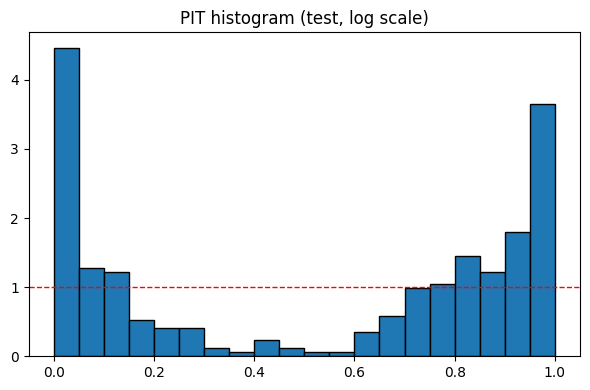

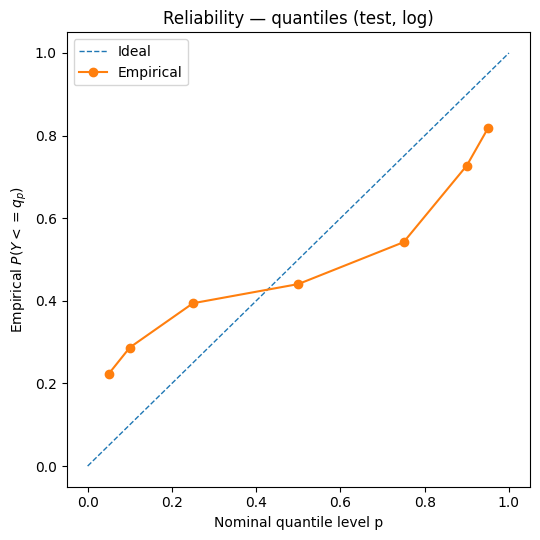

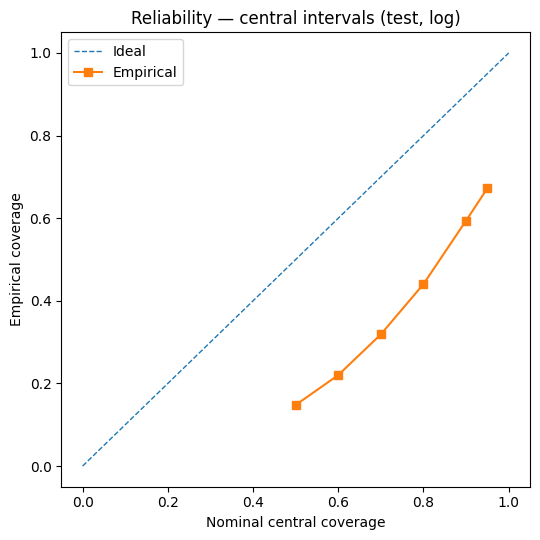

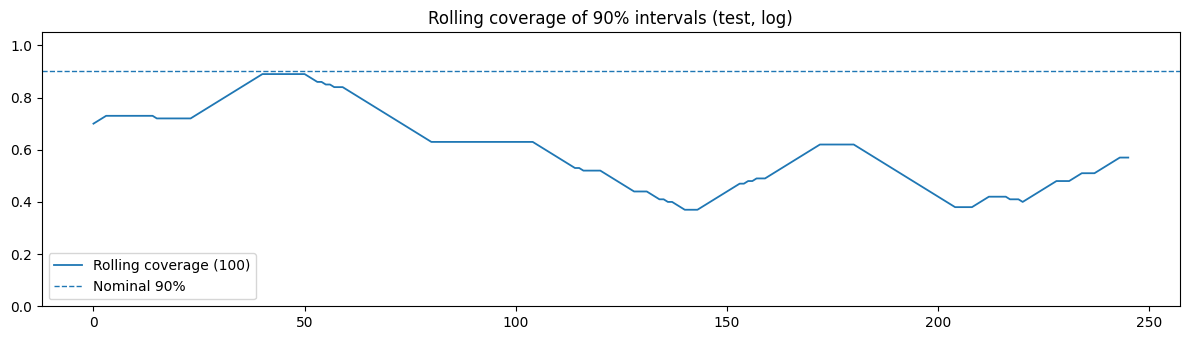

[Saved] plots/siggp_test_metrics_log.csv


In [ ]:
# metrics and calibration
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import norm

os.makedirs("plots", exist_ok=True)

def interval_score(alpha, l, u, y):
    width = u - l
    under = (l - y) if y < l else 0.0
    over  = (y - u) if y > u else 0.0
    return width + (2.0/alpha)*under + (2.0/alpha)*over

def crps_gaussian(y, mu, sig):
    z   = (y - mu) / np.maximum(sig, 1e-12)
    pdf = norm.pdf(z); cdf = norm.cdf(z)
    return sig * (z * (2*cdf - 1) + 2*pdf - 1/np.sqrt(np.pi))

def summarize_split(name, res, alpha=0.10, save_prefix="siggp"):
    mu  = res["mu_log"]
    tl  = res["true_log"]
    s   = np.sqrt(res["var_log"])
    lo  = mu + norm.ppf(alpha/2) * s
    hi  = mu + norm.ppf(1 - alpha/2) * s

    # point metrics
    mae = float(mean_absolute_error(tl, mu))
    mse = float(mean_squared_error(tl, mu))

    # interval metrics
    cov = float(np.mean((tl >= lo) & (tl <= hi)))
    wid = float(np.mean(hi - lo))
    isv = float(np.mean([interval_score(alpha, lo[i], hi[i], tl[i]) for i in range(len(tl))]))

    # CRPS (Gaussian closed-form)
    crp = float(np.mean(crps_gaussian(tl, mu, s)))

    print(f"[{name}] MAE={mae:.6f}  MSE={mse:.6f}  Cov90={cov:.3f}  "
          f"Width90={wid:.6f}  IS90={isv:.6f}  CRPS={crp:.6f}")

    #  PIT histogram 
    pit = norm.cdf((tl - mu) / np.maximum(s, 1e-12))
    plt.figure(figsize=(6,4))
    plt.hist(pit, bins=20, range=(0,1), density=True, edgecolor="k")
    plt.axhline(1.0, color="r", linestyle="--", linewidth=1.0)
    plt.title(f"PIT histogram ({name}, log scale)")
    plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_pit.png", dpi=160); plt.show()

    #  Reliability: quantiles 
    qgrid = np.array([0.05, 0.10, 0.25, 0.50, 0.75, 0.90, 0.95])
    emp   = []
    for p in qgrid:
        q = mu + norm.ppf(p) * s
        emp.append(np.mean(tl <= q))
    emp = np.array(emp)

    xx = np.linspace(0,1,201)
    plt.figure(figsize=(5.5,5.5))
    plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
    plt.plot(qgrid, emp, "o-", lw=1.5, label="Empirical")
    plt.xlabel("Nominal quantile level p"); plt.ylabel(r"Empirical $P(Y <= q_p)$")
    plt.title(f"Reliability — quantiles ({name}, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_reliab_quant.png", dpi=160); plt.show()

    #  Reliability: central intervals
    cgrid = np.array([0.50, 0.60, 0.70, 0.80, 0.90, 0.95])
    emp_c = []
    for c in cgrid:
        a = (1-c)/2.0; b = 1 - a
        lo_c = mu + norm.ppf(a) * s
        hi_c = mu + norm.ppf(b) * s
        emp_c.append(np.mean((tl >= lo_c) & (tl <= hi_c)))
    emp_c = np.array(emp_c)

    plt.figure(figsize=(5.5,5.5))
    plt.plot(xx, xx, "--", lw=1.0, label="Ideal")
    plt.plot(cgrid, emp_c, "s-", lw=1.5, label="Empirical")
    plt.xlabel("Nominal central coverage"); plt.ylabel("Empirical coverage")
    plt.title(f"Reliability — central intervals ({name}, log)")
    plt.legend(); plt.tight_layout()
    plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_reliab_central.png", dpi=160); plt.show()

    #  Rolling coverage 
    win = 100
    covered = ((tl >= lo) & (tl <= hi)).astype(float)
    if len(covered) >= win:
        roll = np.convolve(covered, np.ones(win)/win, mode="valid")
        plt.figure(figsize=(12,3.5))
        plt.plot(roll, lw=1.3, label=f"Rolling coverage ({win})")
        plt.axhline(0.90, ls="--", lw=1.0, label="Nominal 90%")
        plt.ylim(0,1.05)
        plt.title(f"Rolling coverage of 90% intervals ({name}, log)")
        plt.legend(); plt.tight_layout()
        plt.savefig(f"plots/gp2/{save_prefix}_{name.lower()}_rolling_cov.png", dpi=160); plt.show()

    return {"MAE": mae, "MSE": mse, "Coverage90": cov, "Width90": wid, "IS90": isv, "CRPS": crp}

metrics_te = summarize_split("test",  res_te, alpha=0.10, save_prefix="siggp")

import pandas as pd
pd.DataFrame([{"Model":"Signature GP (test)",
               **metrics_te}]).to_csv("plots/siggp_test_metrics_log.csv", index=False)
print("[Saved] plots/siggp_test_metrics_log.csv")


[ACI] q̂_(1-α) from validation: 4.383
[SigGP + ACI lag 30] MSE(log)=0.061923  Coverage=0.907  Width=0.952341  Interval Score 90=1.050857


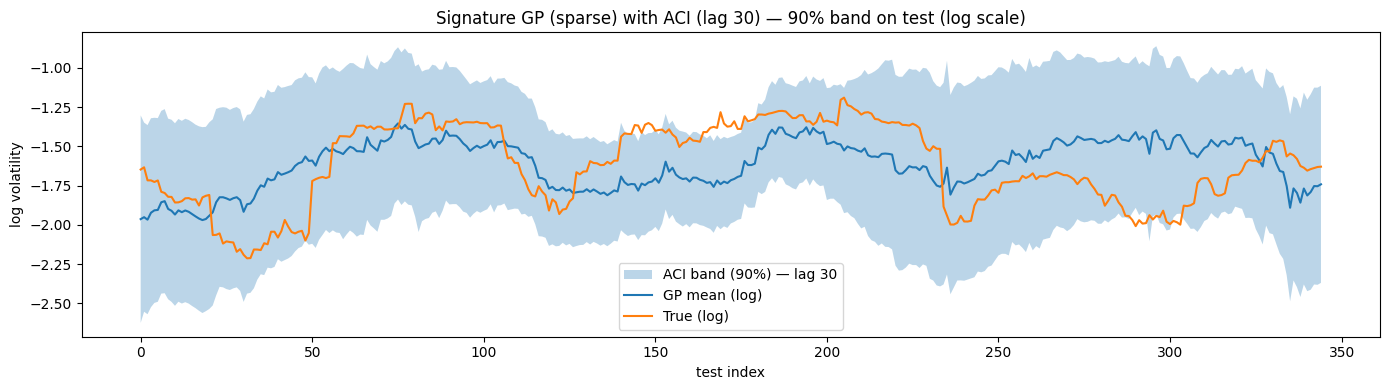

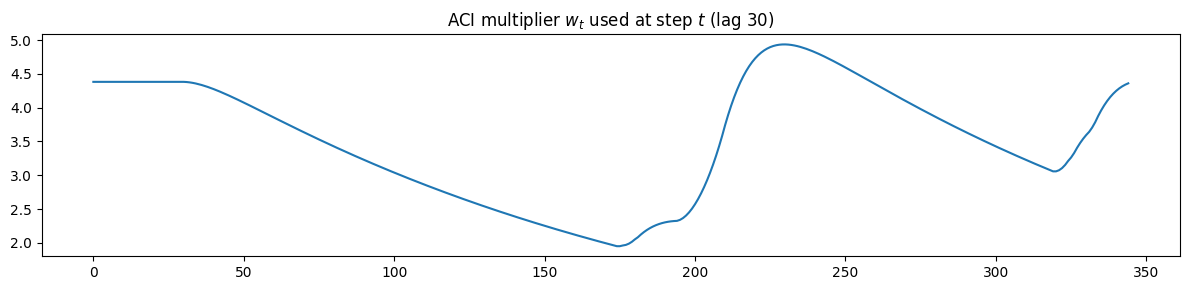

In [ ]:
#  ACI (90%) for Signature GP
import os, numpy as np, matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

os.makedirs("plots/siggp", exist_ok=True)

# Config
alpha  = 0.10     # 90% central interval
H      = 30       # horizon
beta   = 0.90     # EMA smoothing for misses
k_gain = 0.06     # multiplicative gain
w_min  = 0.05     # anti-windup lower
w_max  = 5.0      # anti-windup upper
sd_floor = 1e-8   # protects against tiny std on log scale

def gp_mu_sd_log_batch(model, X_seq, chunk=128):
    """Return mu_log, sd_log arrays for a whole split."""
    mu_s, var_s = _pred_scaled_batched(model, X_seq, chunk=chunk)  
    mu_log, var_log = _unscale_log(mu_s, var_s)                    
    sd_log = np.sqrt(np.maximum(var_log, 0.0))
    return mu_log, sd_log

mu_va_log, sd_va_log = gp_mu_sd_log_batch(model, X_va, chunk=PRED_CHUNK)
y_va_log = scaler_y.inverse_transform(y_va.reshape(-1,1)).ravel()

scores = np.abs(y_va_log - mu_va_log) / np.maximum(sd_va_log, sd_floor)
scores = scores[np.isfinite(scores)]
w0 = float(np.quantile(scores, 1 - alpha)) if scores.size else 1.0
print(f"[ACI] q̂_(1-α) from validation: {w0:.3f}")

mu_te_log, sd_te_log = gp_mu_sd_log_batch(model, X_te, chunk=PRED_CHUNK)
y_te_log = scaler_y.inverse_transform(y_te.reshape(-1,1)).ravel()

n_te = len(y_te_log)
mu_arr = np.full(n_te, np.nan)
sd_arr = np.full(n_te, np.nan)
lo_arr = np.full(n_te, np.nan)
hi_arr = np.full(n_te, np.nan)
w_used = np.full(n_te, np.nan)

w = float(np.clip(w0, w_min, w_max))
miss_ema = alpha  # neutral start

#  Online ACI with horizon-lagged updates 
for i in range(n_te):
    mu_i = float(mu_te_log[i])
    sd_i = float(max(sd_te_log[i], sd_floor))

    mu_arr[i] = mu_i
    sd_arr[i] = sd_i
    lo_arr[i] = mu_i - w * sd_i
    hi_arr[i] = mu_i + w * sd_i
    w_used[i] = w

    j = i - H  
    if j >= 0 and np.isfinite(y_te_log[j]) and np.isfinite(lo_arr[j]) and np.isfinite(hi_arr[j]):
        miss = 0.0 if (lo_arr[j] <= y_te_log[j] <= hi_arr[j]) else 1.0
        miss_ema = beta * miss_ema + (1 - beta) * miss
        w = float(np.clip(w * np.exp(k_gain * (miss_ema - alpha)), w_min, w_max))

#  Metrics
mask = np.isfinite(mu_arr) & np.isfinite(lo_arr) & np.isfinite(hi_arr) & np.isfinite(y_te_log)
y_eff  = y_te_log[mask]
mu_eff = mu_arr[mask]
lo_eff = lo_arr[mask]
hi_eff = hi_arr[mask]

def interval_score(alpha, l, u, y):
    width = u - l
    return width + (2.0/alpha)*np.maximum(l - y, 0.0) + (2.0/alpha)*np.maximum(y - u, 0.0)

cov  = float(np.mean((y_eff >= lo_eff) & (y_eff <= hi_eff)))
wid  = float(np.mean(hi_eff - lo_eff))
mse  = float(mean_squared_error(y_eff, mu_eff))
is90 = float(np.mean([interval_score(alpha, lo_eff[t], hi_eff[t], y_eff[t]) for t in range(len(y_eff))]))

print(f"[SigGP + ACI lag {H}] MSE(log)={mse:.6f}  Coverage={cov:.3f}  Width={wid:.6f}  Interval Score 90={is90:.6f}")

# Plot
x = np.arange(n_te)
plt.figure(figsize=(14,4))
plt.fill_between(x, lo_arr, hi_arr, alpha=.30, label=f'ACI band (90%) — lag {H}')
plt.plot(mu_arr, label='GP mean (log)'); plt.plot(y_te_log, label='True (log)')
plt.title(f'Signature GP (sparse) with ACI (lag {H}) — 90% band on test (log scale)')
plt.xlabel('test index'); plt.ylabel('log volatility'); plt.legend()
plt.tight_layout()
plt.savefig("plots/gp2/siggp_aci_test_band_log.png", dpi=160)
plt.show()

plt.figure(figsize=(12,3.0))
plt.plot(w_used)
plt.title(f'ACI multiplier $w_t$ used at step $t$ (lag {H})')
plt.tight_layout(); plt.show()


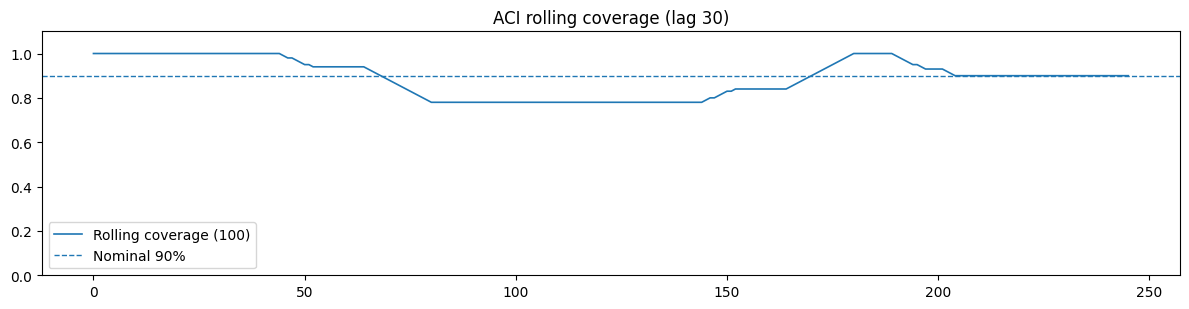

w0 (from val): 4.383
w_used mean:   3.507  median: 3.574  last: 4.361
[Saved] plots/gp2/siggp_aci_test_metrics_log.csv


In [ ]:
# Rolling coverage of the ACI band 
import numpy as np, matplotlib.pyplot as plt, os, pandas as pd

os.makedirs("plots/gp2", exist_ok=True)

win = 100
covered = ((y_eff >= lo_eff) & (y_eff <= hi_eff)).astype(float)
if len(covered) >= win:
    roll = np.convolve(covered, np.ones(win)/win, mode="valid")
    plt.figure(figsize=(12,3.2))
    plt.plot(roll, lw=1.2, label=f"Rolling coverage ({win})")
    plt.axhline(0.90, ls="--", lw=1.0, label="Nominal 90%")
    plt.ylim(0, 1.1)
    plt.legend()
    plt.title("ACI rolling coverage (lag 30)")
    plt.tight_layout()
    plt.savefig("plots/gp2/siggp_aci_coverage_by_time.png", dpi=160)
    plt.show()
else:
    print(f"[ACI] Not enough points for rolling window (need ≥ {win}, have {len(covered)}).")

print(f"w0 (from val): {w0:.3f}")
print(f"w_used mean:   {np.nanmean(w_used):.3f}  median: {np.nanmedian(w_used):.3f}  last: {w_used[~np.isnan(w_used)][-1]:.3f}")

row = {
    "Model": "SigGP + ACI (lag 30)",
    "H": 30, "beta": 0.9, "k": 0.06, "w0": float(w0),
    "MSE_log": float(mse), "Coverage90": float(cov),
    "AvgWidth90": float(wid), "IntervalScore90": float(is90),
}
pd.DataFrame([row]).to_csv("plots/gp2/siggp_aci_test_metrics_log.csv", index=False)
print("[Saved] plots/gp2/siggp_aci_test_metrics_log.csv")
